In [1]:
import types
import pandas as pd
import numpy as np
from pandas import read_excel as re

df_data_1 =pd.DataFrame(pd.read_csv("Data/Market Data/DCOILBRENTEU.csv"))
df_data_1.head()


,DATE,DCOILBRENTEU
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


Data Source

U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, January 10, 2018.

In [2]:
df_data_1 = df_data_1[df_data_1.DCOILBRENTEU != "."]
print(df_data_1.shape)


(8587, 2)


In [3]:
import matplotlib.pyplot as plt
df_data_1.iloc[:,1:2]=df_data_1.iloc[:,1:2].values.astype(np.float)
df_data_1_plot = df_data_1.iloc[:,1:2].values
df_data_1_plot
# Visualising the Data

array([[18.63],
       [18.45],
       [18.55],
       ...,
       [69.34],
       [68.87],
       [68.78]], dtype=object)

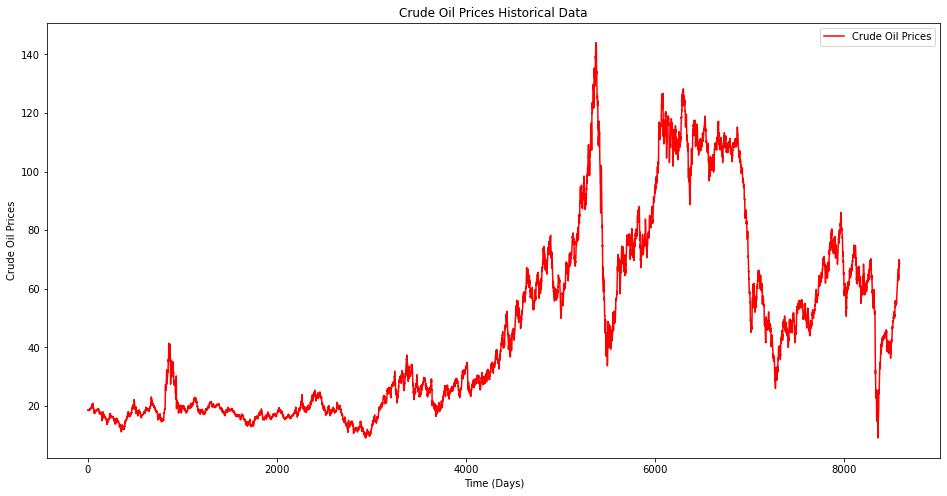

In [4]:
fig = plt.figure(figsize = (16,8))
plt.plot(df_data_1_plot, color = 'red', label = 'Crude Oil Prices')
plt.title('Crude Oil Prices Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.show()

In [5]:
df_data_1['ret_brent'] = (df_data_1.iloc[1:,1:2] - df_data_1.iloc[1:,1:2].shift(1))/df_data_1.iloc[1:,1:2]
df_data_1.head()


,DATE,DCOILBRENTEU,ret_brent
0,1987-05-20,18.63,NaN
1,1987-05-21,18.45,NaN
2,1987-05-22,18.55,0.00539084
3,1987-05-25,18.6,0.00268817
4,1987-05-26,18.63,0.00161031


In [6]:
def importData(FileName,df_merged,firstTime):
    FileLocation = "./Data/Market Data/" + FileName + ".xlsx"
    df_file = re(FileLocation).iloc[6:,0:2]
    df_file = df_file.iloc[::-1]
    df_file[FileName] = (df_file.iloc[1:,1:2] - df_file.iloc[1:,1:2].shift(1))/df_file.iloc[1:,1:2]
    df_file.reset_index(inplace = True)
    df_file.set_index(keys = 'Security', inplace = True)
    if firstTime == False:
        df_merged = pd.merge(left = df_file[FileName],right = df_merged, left_index=True, right_index=True)
    else:
        df_merged = df_file[FileName]
    df_merged.dropna(inplace=True)
    return df_merged

#choose data with size larger than 50KB, to ensure enough data size
#df_PCA = importData("CL1 COMB Comdty","",True)
df_PCA = importData("SPX Index","",True)
df_PCA = importData("VIX Index",df_PCA,False)
df_PCA = importData("DXY Curncy",df_PCA,False)
df_PCA = importData("OPECDALY Indexl",df_PCA,False)
df_PCA = importData("SPSIOP Index",df_PCA,False)
df_PCA = importData("DWCOGS Index",df_PCA,False)
df_PCA = importData("GEAE Index",df_PCA,False)
df_PCA = importData("DWCOGST Index",df_PCA,False)
df_PCA = importData("SCP1 COMB Comdty",df_PCA,False)



In [7]:
df_data_1['date']=df_data_1['DATE'].apply(pd.Timestamp)

In [8]:
df_data_1.set_index(keys = 'date', inplace = True)

In [9]:
df_PCA = pd.merge(left = df_PCA,right = df_data_1.ret_brent, left_index=True, right_index=True)

In [10]:
df_PCA.dropna(inplace=True)
df_Target = df_PCA

In [11]:
df_PCA = df_PCA.drop(['ret_brent'], axis=1)

In [12]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


X = df_PCA
y = df_Target.ret_brent


pca = PCA(n_components=7)
pca.fit(X,y)
x_new = pca.transform(X)   

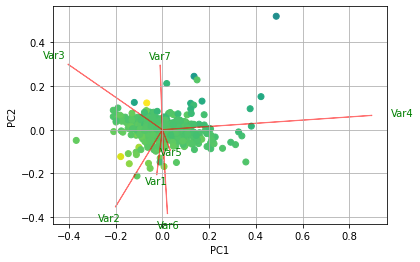

In [13]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]

    plt.scatter(xs ,ys, c = y) #without scaling
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. 
myplot(x_new[:,0:2], pca. components_) 
plt.show()

In [14]:

# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = list(X.columns)
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_most_important = pd.DataFrame(dic.items())

In [15]:
df_most_important

,0,1
0,PC0,VIX Index
1,PC1,OPECDALY Indexl
2,PC2,OPECDALY Indexl
3,PC3,SCP1 COMB Comdty
4,PC4,GEAE Index
5,PC5,SPSIOP Index
6,PC6,SPX Index


In [16]:
df_most_important.columns = ['PC','ticker']
names = ["VIX Index","OPEC Daily Index","OPEC Daily Index","Crude Oil Futures","MSCI Global Alternative Index","S&P Oil&Gas Exploration & Production Select Industry Index","SP 500 Index "]
df_most_important["name"] = names
df_most_important

,PC,ticker,name
0,PC0,VIX Index,VIX Index
1,PC1,OPECDALY Indexl,OPEC Daily Index
2,PC2,OPECDALY Indexl,OPEC Daily Index
3,PC3,SCP1 COMB Comdty,Crude Oil Futures
4,PC4,GEAE Index,MSCI Global Alternative Index
5,PC5,SPSIOP Index,S&P Oil&Gas Exploration & Production Select In...
6,PC6,SPX Index,SP 500 Index
